# Boston Housing Price Prediction
### End-to-End Machine Learning Pipeline

**Objective:** Predict median housing prices in Boston using 13 neighborhood features.  
**Approach:** Compare 10 regression models, engineer new features based on EDA insights, and optimize top performers with GridSearchCV.  
**Best Result:** LightGBM — R² = 0.891, RMSE = $2,509

---

## 1. Environment Setup & Imports

In [137]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")



from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, SelectKBest, f_regression
import xgboost as xgb
import lightgbm as lgb

# visulation settings
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
%matplotlib inline

## 2. Data Loading

The Boston Housing dataset was originally published by Harrison & Rubinfeld (1978). It contains **506 samples** with **13 features** describing various neighborhood characteristics (crime rate, number of rooms, proximity to employment centers, etc.) and a **target variable (PRICE)** representing the median home value in $1,000s.

> **Note:** Since `sklearn.datasets.load_boston()` was deprecated in scikit-learn 1.2 due to ethical concerns, the data is loaded directly from the CMU StatLib archive.

In [138]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

feature_names = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
    'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'
]

# Convert the Dataframe
df = pd.DataFrame(data, columns=feature_names)
df['PRICE'] = target


## 3. Initial Data Exploration

Let's examine the dataset dimensions, structure, data types, and check for missing values or duplicates.

In [139]:
# shape
print(f"data shape : {df.shape}\n")

# first view
df.head(10)

veri seti boyutu (506, 14)



,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


In [140]:
#  view dataset columns
df_col = df.columns.to_list()
print(f"Columns: {df_col}\nNumber of features: {len(df_col)}")

veri seti sütunları ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']
 özellik sayısı : 14


In [141]:
# general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [142]:
# duplicated control

df.duplicated().sum()

np.int64(0)

### Initial Observations

| Check | Result |
|-------|--------|
| Samples | 506 |
| Features | 13 (all numerical) |
| Target | PRICE (continuous → regression problem) |
| Missing values | None |
| Duplicate rows | None |

All features are numerical, and there are no missing values or duplicates. This is a **supervised regression** problem.

---

## 4. Exploratory Data Analysis (EDA)

### 4.1 Target Variable Analysis

Understanding the distribution of the target variable is critical before choosing models and transformations. We look for **skewness**, **outliers**, and **central tendency**.

In [143]:

target = df["PRICE"]

# Describtive analysis
target.describe().T

,PRICE
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000


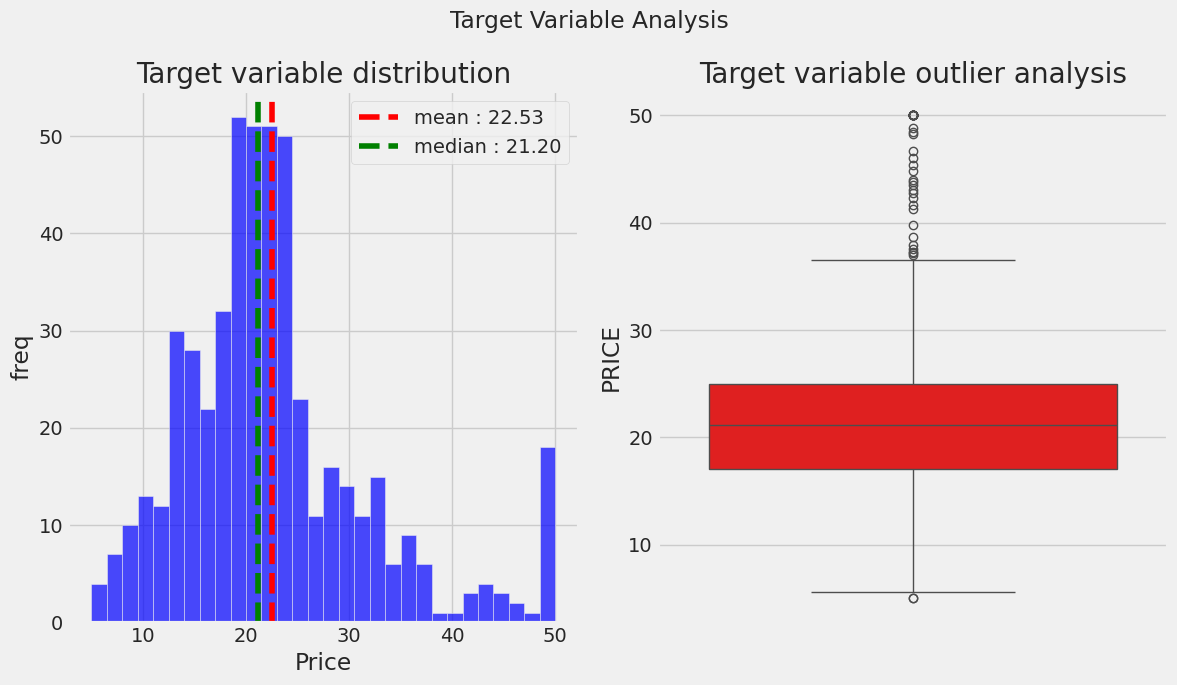


target skew : 1.11
target kurt : 1.50


In [144]:
# target distribution

fig, axes  = plt.subplots(1,2,figsize=(12,7))
plt.suptitle("Target Variable Analysis")

axes[0].hist(target,bins = 30,color = "blue",alpha =0.7)
axes[0].axvline(target.mean(),color ="red",linestyle ="--"
,label =f"mean : {target.mean():.2f}")
axes[0].axvline(target.median(),color ="green",linestyle="--",
                label =f"median : {target.median():.2f}")
axes[0].set_title("Target variable distribution")
axes[0].set_xlabel("Price")
axes[0].set_ylabel("freq")

axes[0].legend()

# outlier
sns.boxplot(y= target,ax = axes[1],color ="red")
axes[1].set_title("Target variable outlier analysis")

plt.tight_layout()
plt.show()

print(f"\ntarget skew : {target.skew():.2f}")
print(f"target kurt : {target.kurt():.2f}")

**Key Findings:**
- The target variable shows **right skewness** (positive skew), meaning there are some very high-priced homes pulling the distribution tail to the right.
- The mean ($22.5k) is higher than the median ($21.2k), confirming the skew.
- There are visible **outliers** at the upper end (homes priced near $50k, which appears to be a cap value).
- **Action:** Log transformation will be applied later to normalize this distribution.

---

### 4.2 Correlation Analysis

A correlation heatmap helps identify:
1. Which features are **strongly correlated with the target** (useful predictors)
2. Which features are **highly correlated with each other** (multicollinearity risk)

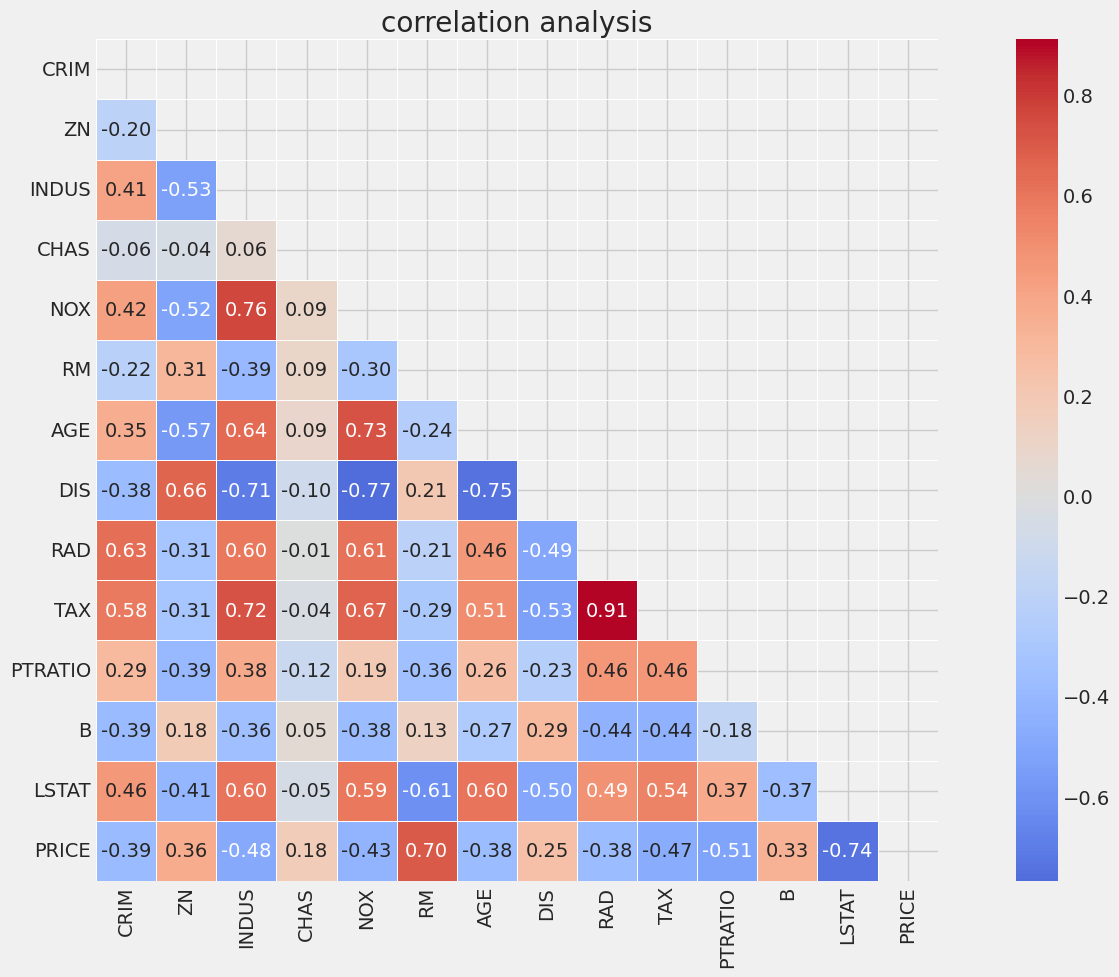

In [145]:
# correlation analysis of numerical variables
df_corr = df.corr()

# correlation visualization
plt.figure(figsize=(16,10))
mask =np.triu(np.ones_like(df_corr,dtype = bool))
sns.heatmap(df_corr,mask = mask,annot = True,cmap ="coolwarm",
            fmt =".2f",center = 0,square=True,linewidths=0.5)
plt.title("correlation analysis")

plt.tight_layout()
plt.show()

In [146]:
Multicorr = [("RAD","TAX"),("AGE","DIS"),("NOX","DIS")]

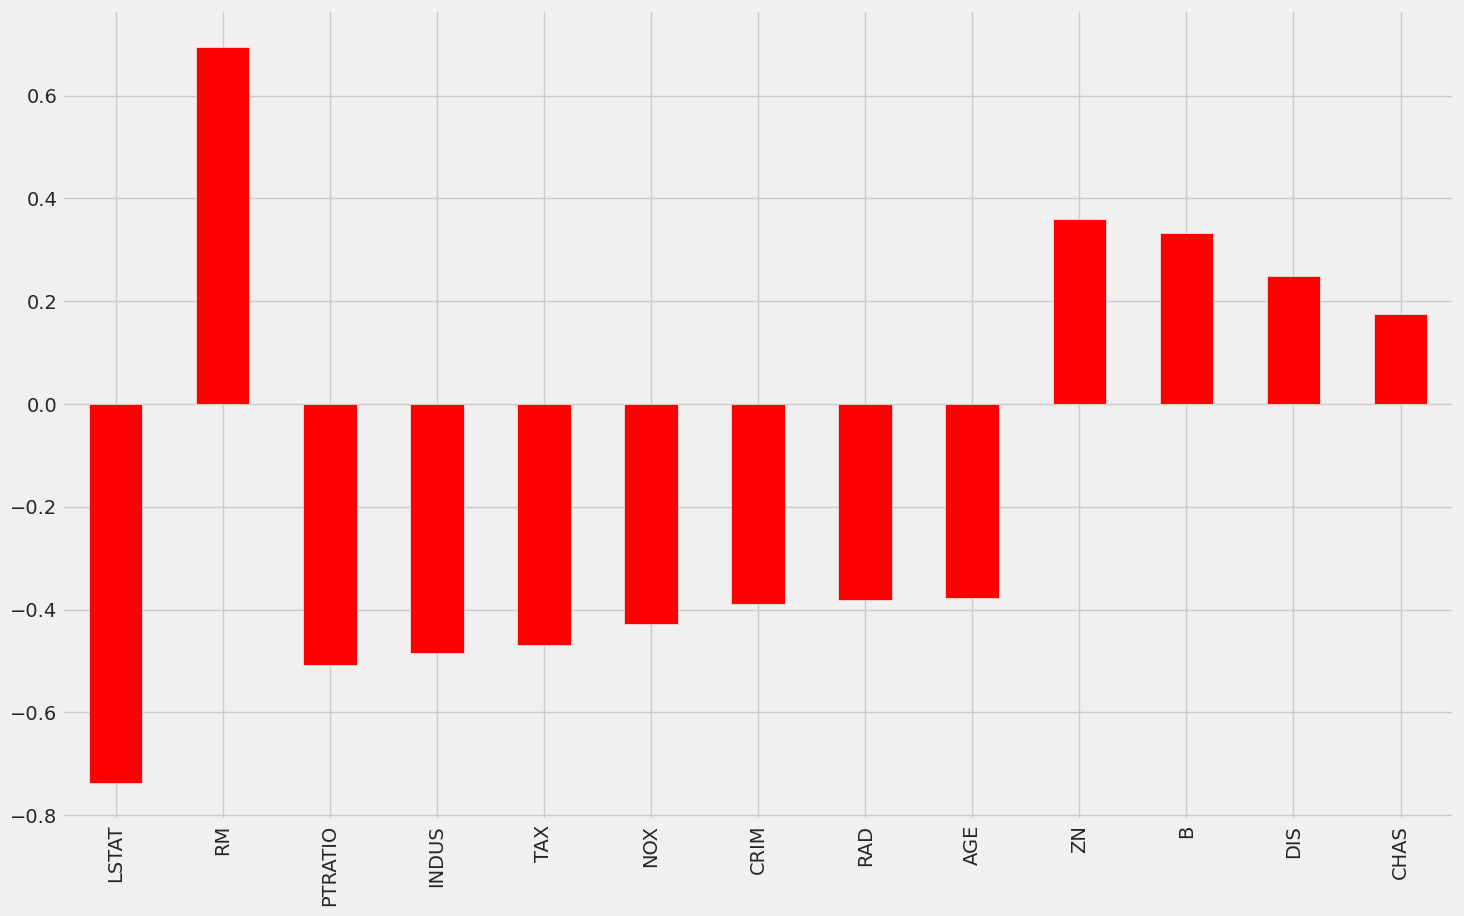

In [147]:
# correlation with the target variable

top_corr = df_corr["PRICE"].sort_values(key = abs , ascending = False)
plt.figure(figsize=(16,10))
top_corr.drop("PRICE").plot(kind = "bar",color = "red")

plt.show()



**Key Findings:**
- **Strongest positive correlation** with PRICE: **RM** (avg. rooms per dwelling) → r = 0.70
- **Strongest negative correlation** with PRICE: **LSTAT** (% lower status population) → r = −0.74
- **Multicollinearity detected** between:
  - RAD ↔ TAX (r = 0.91) — Highway accessibility and tax rate move together
  - AGE ↔ DIS (r = −0.75) — Older neighborhoods tend to be closer to employment centers
  - NOX ↔ DIS (r = −0.77) — Pollution decreases with distance from industrial areas

These multicollinear pairs will be addressed with VIF analysis and feature engineering.

---

### 4.3 Variance Inflation Factor (VIF) Analysis

Correlation heatmaps show pairwise relationships, but **VIF** detects multicollinearity considering *all* features simultaneously. A VIF > 10 indicates problematic multicollinearity.

In [148]:
# VIF control
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Only numerical columns, NaNs cleaned
num_features = df.select_dtypes(include=[np.number]).dropna()

# Remove the target variable
num_features = num_features.drop("PRICE", axis=1)

# Calculate VIF
vif_data = pd.DataFrame({
    "Feature": num_features.columns,
    "VIF": [variance_inflation_factor(num_features.values, i) for i in range(num_features.shape[1])]
})

print(vif_data.sort_values("VIF", ascending=False))


    Feature        VIF
10  PTRATIO  85.029547
5        RM  77.948283
4       NOX  73.894947
9       TAX  61.227274
6       AGE  21.386850
11        B  20.104943
8       RAD  15.167725
7       DIS  14.699652
2     INDUS  14.485758
12    LSTAT  11.102025
1        ZN   2.844013
0      CRIM   2.100373
3      CHAS   1.152952


---

### 4.4 Feature vs Target Scatter Plots

Visualizing each feature against PRICE reveals the nature of relationships (linear, non-linear, heteroscedastic) and helps identify potential outliers.

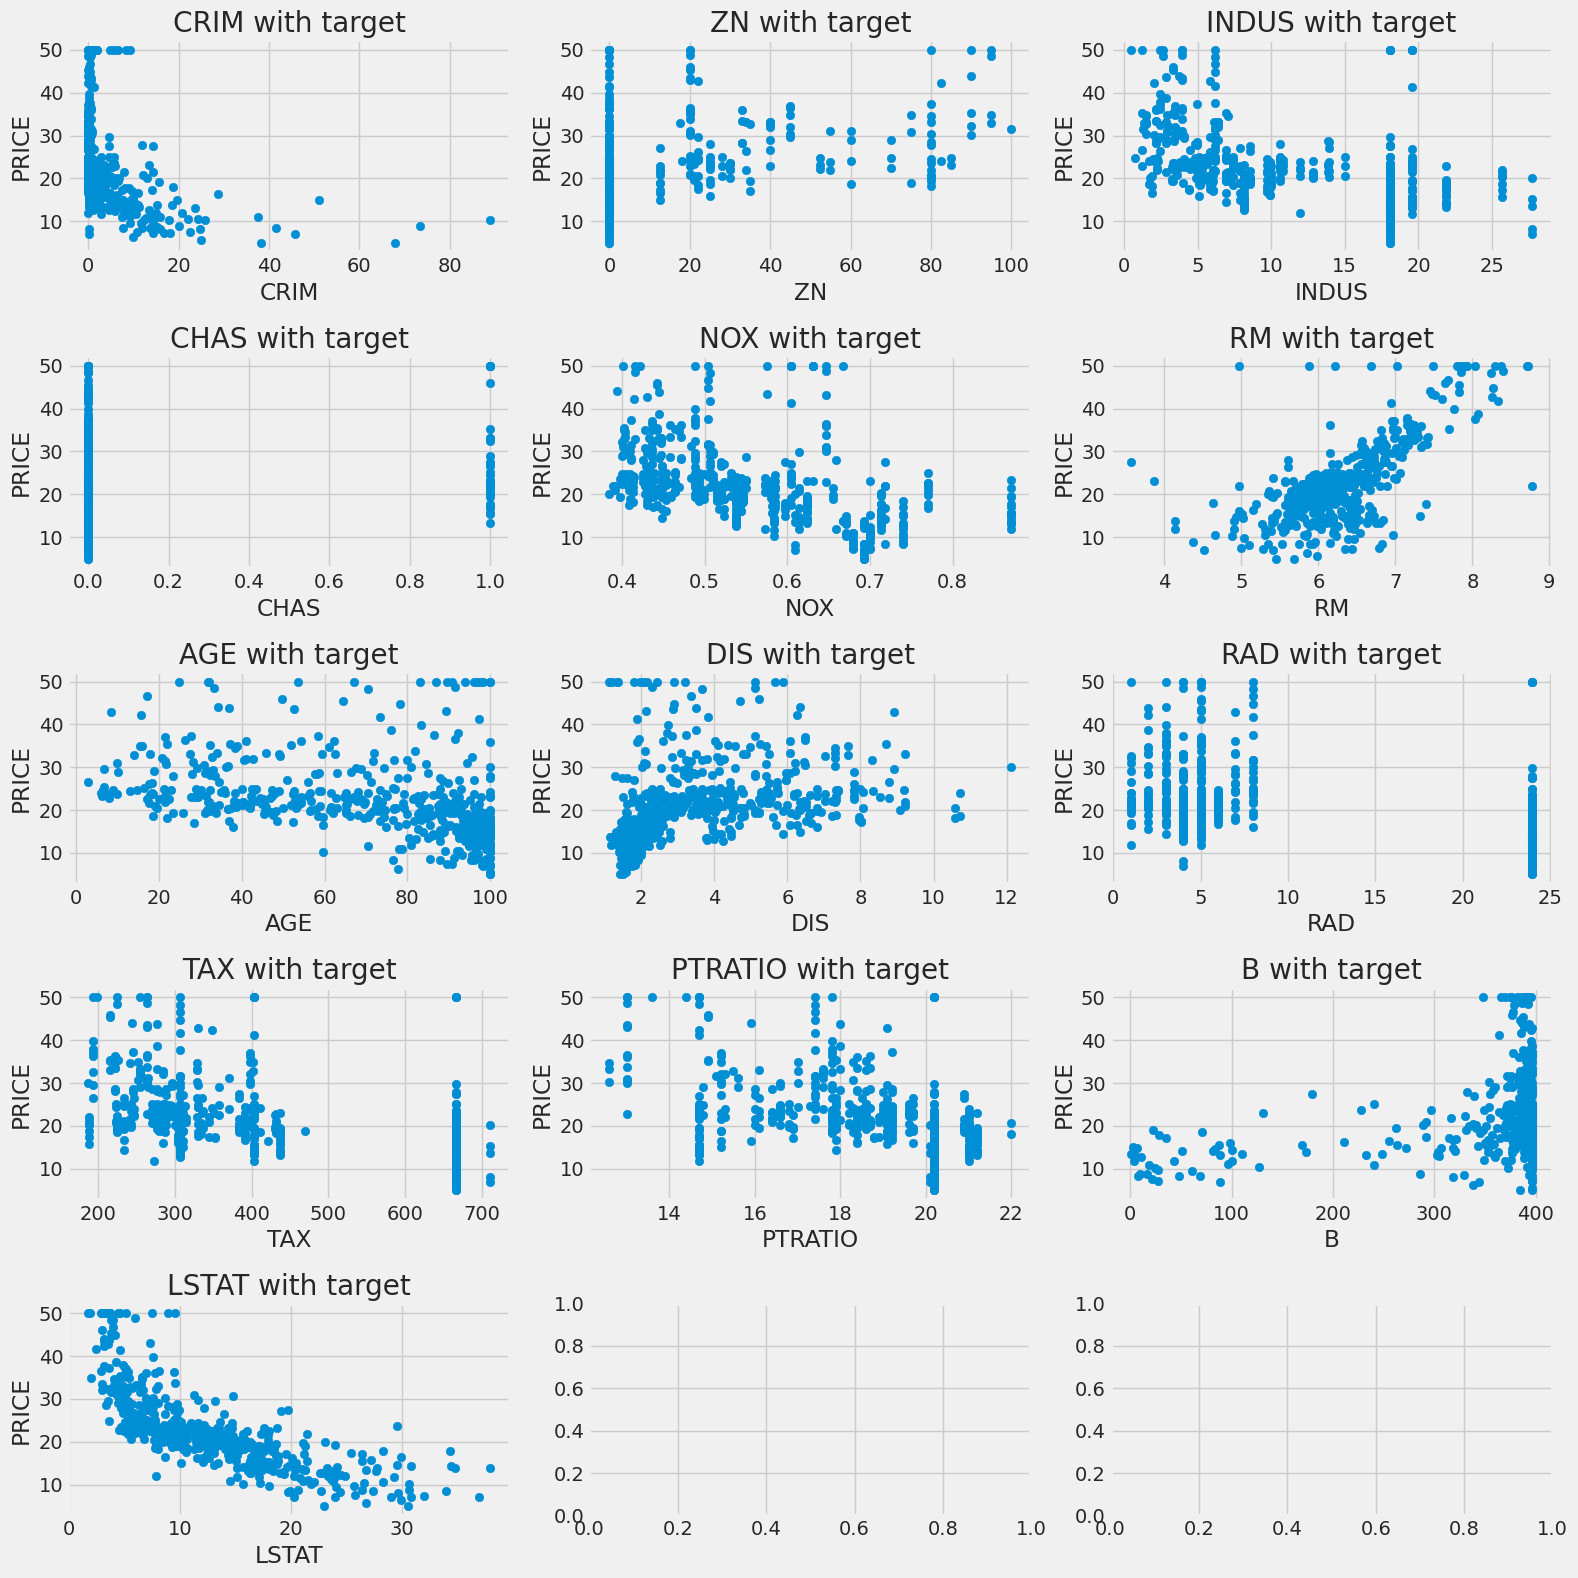

In [149]:
# distributions of characteristics according to the target variable

fig, axes = plt.subplots(5, 3, figsize=(16,16))
axes = axes.flatten()

for index, feature in enumerate(df_col[:-1]):
  axes[index].scatter(x = df[feature], y =target)
  axes[index].set_xlabel(feature)
  axes[index].set_ylabel("PRICE")
  axes[index].set_title(f"{feature} with target")

plt.tight_layout()

**Key Observations:**
- **RM vs PRICE**: Clear positive linear trend — more rooms → higher price.
- **LSTAT vs PRICE**: Non-linear (curved) negative relationship — log or polynomial transformation may help.
- **CRIM**: Heavily right-skewed with most values near zero and a few extreme outliers.
- **DIS, NOX**: Show non-linear patterns that may benefit from interaction terms.

---

### 4.5 Outlier Analysis (IQR Method)

Using the Interquartile Range (IQR) method to quantify outliers across all features. Values below Q1 − 1.5×IQR or above Q3 + 1.5×IQR are flagged as outliers.

> **Decision:** Rather than removing outliers (which would reduce our already small dataset), we'll use **RobustScaler** during preprocessing — it uses median and IQR instead of mean and std, making it resistant to extreme values.

In [150]:
# outlier analysis
outlier_data = [] # create an empty list
for feature in num_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percent = (outlier_count / len(df)) * 100

    outlier_data.append({'feature': feature,
        'outlier_count': outlier_count,
        'outlier_pct': outlier_percent,
        'Min': df[feature].min(),
        'Q1': Q1,
        'Median': df[feature].median(),
        'Q3': Q3,
        'Max': df[feature].max(),
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    })
outlier_summary = pd.DataFrame(outlier_data)
outlier_summary = outlier_summary.sort_values(by='outlier_pct', ascending=False)
outlier_summary.reset_index(drop=True, inplace=True)
outlier_summary

,Özellik,outlier_count,outlier_pct,Min,Q1,Median,Q3,Max,IQR,lower_bound,upper_bound
0,B,77,15.217391,0.32000,375.377500,391.44000,396.225000,396.9000,20.847500,344.106250,427.496250
1,ZN,68,13.438735,0.00000,0.000000,0.00000,12.500000,100.0000,12.500000,-18.750000,31.250000
2,CRIM,66,13.043478,0.00632,0.082045,0.25651,3.677083,88.9762,3.595038,-5.310511,9.069639
3,CHAS,35,6.916996,0.00000,0.000000,0.00000,0.000000,1.0000,0.000000,0.000000,0.000000
4,RM,30,5.928854,3.56100,5.885500,6.20850,6.623500,8.7800,0.738000,4.778500,7.730500
5,PTRATIO,15,2.964427,12.60000,17.400000,19.05000,20.200000,22.0000,2.800000,13.200000,24.400000
6,LSTAT,7,1.383399,1.73000,6.950000,11.36000,16.955000,37.9700,10.005000,-8.057500,31.962500
7,DIS,5,0.988142,1.12960,2.100175,3.20745,5.188425,12.1265,3.088250,-2.532200,9.820800
8,INDUS,0,0.000000,0.46000,5.190000,9.69000,18.100000,27.7400,12.910000,-14.175000,37.465000
9,NOX,0,0.000000,0.38500,0.449000,0.53800,0.624000,0.8710,0.175000,0.186500,0.886500


---

## 5. Data Preprocessing

### 5.1 Target Variable Transformation (Log)

The target variable (PRICE) showed right skewness in our EDA. Applying `log1p` transformation will:
- Reduce the impact of high-price outliers
- Make the distribution more symmetric (closer to normal)
- Improve performance of models that assume normally distributed residuals

In [151]:

# Log Transformation

# copy an original target
df['PRICE_ORIGINAL'] = df['PRICE'].copy()

# Log transformation
df['PRICE'] = np.log1p(df['PRICE'])

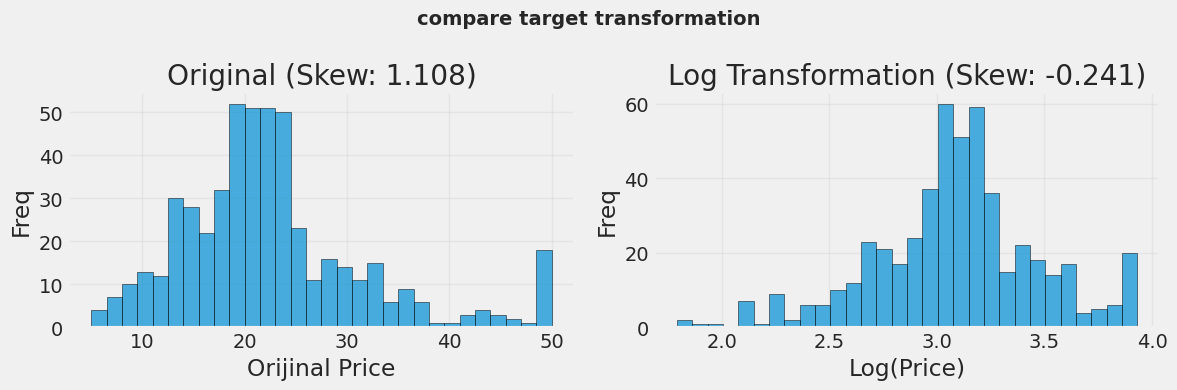

  Original: 1.108
  Log target: -0.241


In [152]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Target Variable: Before & After Log Transformation', ...)

# Orijinal
axes[0].hist(df['PRICE_ORIGINAL'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Original Price')
axes[0].set_ylabel('Freq')
axes[0].set_title(f'Original (Skew: {df["PRICE_ORIGINAL"].skew():.3f})')
axes[0].grid(True, alpha=0.3)

# Log transformation
axes[1].hist(df['PRICE'], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Log(Price)')
axes[1].set_ylabel('Freq')
axes[1].set_title(f'Log Transformation (Skew: {df["PRICE"].skew():.3f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"  Original: {df['PRICE_ORIGINAL'].skew():.3f}")
print(f"  Log target: {df['PRICE'].skew():.3f}")



The skewness dropped significantly after log transformation, confirming it was the right choice.

---

### 5.2 Feature Engineering

Based on EDA findings, we create new features to capture relationships that single features can't express:

| New Feature | Logic | Rationale |
|-------------|-------|-----------|
| `TAX_RAD_RATIO` | TAX / (RAD + 1) | Addresses RAD-TAX multicollinearity (r=0.91) by combining them into a single ratio |
| `NOX_DIS_INTERACTION` | NOX × DIS | Captures the interaction between pollution and distance to employment |
| `LSTAT_RM_INTERACTION` | LSTAT × RM | Combines the two strongest predictors — socioeconomic status and house size |
| `RM_CAT` | Binned RM into categories | Captures non-linear "jumps" in price at certain room thresholds |
| `LSTAT_CAT` | Binned LSTAT into categories | Captures non-linear segments in the LSTAT-PRICE curve |

In [153]:
df['TAX_RAD_RATIO'] = df['TAX'] / (df['RAD'] + 1)


df['NOX_DIS_INTERACTION'] = df['NOX'] * df['DIS']
df['LSTAT_RM_INTERACTION'] = df['LSTAT'] * df['RM']

# binned features
df['RM_CAT'] = pd.cut(df['RM'], bins=[0, 4, 6, 8, 10], labels=["Small", "Medium", "Large", "Very Large"])
df['LSTAT_CAT'] = pd.cut(df['LSTAT'], bins=[0, 10, 20, 30, 40], labels=["Small", "Medium", "Large", "Very Large"])

In [154]:
# one-hot encoding
df = pd.get_dummies(df, columns=['RM_CAT', 'LSTAT_CAT'], drop_first=True)


new_features = ['TAX_RAD_RATIO', 'NOX_DIS_INTERACTION', 'LSTAT_RM_INTERACTION']
for feature in new_features:
    corr_with_target = df[feature].corr(df['PRICE'])
    print(f"  {feature}: corr = {corr_with_target:.3f}")

  TAX_RAD_RATIO: corr = 0.150
  NOX_DIS_INTERACTION: corr = 0.267
  LSTAT_RM_INTERACTION: corr = -0.797


---

### 5.3 Prepare Feature Matrix (X) and Target (y)

In [155]:


X = df.drop(['PRICE', 'PRICE_ORIGINAL'], axis=1)
y = df['PRICE']

In [156]:

# one hot encoding
for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,LSTAT,TAX_RAD_RATIO,NOX_DIS_INTERACTION,LSTAT_RM_INTERACTION,RM_CAT_Medium,RM_CAT_Large,RM_CAT_Very Large,LSTAT_CAT_Medium,LSTAT_CAT_Large,LSTAT_CAT_Very Large
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,...,4.98,148.000000,2.200420,32.74350,0,1,0,0,0,0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,...,9.14,80.666667,2.329570,58.68794,0,1,0,0,0,0
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,...,4.03,80.666667,2.329570,28.95555,0,1,0,0,0,0
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,...,2.94,55.500000,2.776488,20.57412,0,1,0,0,0,0
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,...,5.33,55.500000,2.776488,38.09351,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,...,9.67,136.500000,1.420238,63.75431,0,1,0,0,0,0
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,...,9.08,136.500000,1.310737,55.56960,0,1,0,0,0,0
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,...,5.64,136.500000,1.241977,39.34464,0,1,0,0,0,0
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,...,6.48,136.500000,1.368840,44.02512,0,1,0,0,0,0


### 5.4 Post-Engineering VIF Check

After adding new features and encoding categoricals, we re-run VIF to ensure multicollinearity hasn't worsened.

In [157]:
# VIF check after converting boolean columns in the X DataFrame to int
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Only numerical columns, NaNs removed
# Since X already does not contain PRICE and PRICE_ORIGINAL, we can use X directly
# For VIF calculation, let's ensure all X columns are numerical
# (Booleans were previously converted to int)


vif_data_new = pd.DataFrame({
    "Feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

print(vif_data_new.sort_values("VIF", ascending=False).round(2))

                 Feature     VIF
14   NOX_DIS_INTERACTION  439.94
12                 LSTAT  395.50
7                    DIS  384.75
5                     RM  356.40
15  LSTAT_RM_INTERACTION  334.54
17          RM_CAT_Large  206.90
4                    NOX  183.13
9                    TAX  109.83
10               PTRATIO  105.82
16         RM_CAT_Medium  102.55
8                    RAD   46.35
6                    AGE   22.96
11                     B   22.82
13         TAX_RAD_RATIO   17.30
2                  INDUS   15.00
18     RM_CAT_Very Large   12.46
20       LSTAT_CAT_Large    7.80
19      LSTAT_CAT_Medium    6.97
21  LSTAT_CAT_Very Large    4.61
1                     ZN    3.79
0                   CRIM    2.30
3                   CHAS    1.17


### 5.5 Remove High-VIF Feature

Based on VIF results, TAX still shows high multicollinearity. Since we already captured its information in `TAX_RAD_RATIO`, we can safely drop it.

In [158]:
X = X.drop("TAX",axis = 1)

---

### 5.6 Train-Test Split & Feature Scaling

- **Split ratio:** 80% train / 20% test (stratified shuffle)
- **Scaler:** `RobustScaler` — chosen specifically because our dataset contains significant outliers. Unlike `StandardScaler` (which uses mean/std), `RobustScaler` uses **median and IQR**, making it robust to extreme values.

In [159]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# scaler

robust_scaler = RobustScaler()
X_train_scaled = robust_scaler.fit_transform(X_train)
X_test_scaled = robust_scaler.transform(X_test)



---

## 6. Model Training & Evaluation

### 6.1 Baseline Models

We train **10 regression models** ranging from simple linear models to advanced ensemble methods. Each model is evaluated using:
- **R² Score** — Proportion of variance explained (higher is better)
- **RMSE** — Root Mean Squared Error in original price scale (lower is better)
- **MAE** — Mean Absolute Error in original price scale (lower is better)
- **5-Fold Cross-Validation** — To assess generalization and detect overfitting

> **Note:** Since we applied `log1p()` to the target, predictions are inverse-transformed with `expm1()` before calculating RMSE and MAE in the original dollar scale.

In [160]:


models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=0.01, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}

In [161]:
# 5-fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


In [162]:
all_model_results = []
for model_name, model in models.items():
  model.fit(X_train_scaled, y_train)

  y_pred = model.predict(X_test_scaled)

  y_pred_orig = np.expm1(y_pred)  # Inverse
  y_test_orig = np.expm1(y_test)  # Inverse



  mse = mean_squared_error(y_test_orig, y_pred_orig)
  mae = mean_absolute_error(y_test_orig, y_pred_orig)
  r2 = r2_score(y_test, y_pred)
  rmse = np.sqrt(mse)

  # Cross-validation score
  cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='r2')

  all_model_results.append([model_name, mse, mae, r2, rmse,cv_scores.mean(),cv_scores.std()])



In [163]:
all_model_results = pd.DataFrame(all_model_results, columns=['Model', 'MSE', 'MAE', 'R2', 'RMSE',"cv mean","cv std"])

all_model_results.sort_values(by="R2", ascending=False).reset_index(drop=True)


,Model,MSE,MAE,R2,RMSE,cv mean,cv std
0,Gradient Boosting,7.296532,1.876092,0.878081,2.701209,0.866535,0.012247
1,LightGBM,7.084432,1.783109,0.875952,2.661660,0.844394,0.038874
2,Random Forest,7.958930,1.935765,0.858104,2.821158,0.836745,0.036898
3,XGBoost,8.928824,2.081316,0.851375,2.988114,0.841041,0.030473
4,Linear Regression,14.082045,2.189026,0.802870,3.752605,0.790238,0.057124
5,Ridge Regression,15.160273,2.347892,0.785398,3.893620,0.792324,0.049950
6,SVR,12.987837,2.203586,0.784182,3.603864,0.810951,0.072029
7,ElasticNet,16.752582,2.528698,0.758576,4.092992,0.788538,0.055261
8,Lasso Regression,17.994302,2.618809,0.742018,4.241969,0.778982,0.059861
9,KNN,18.396327,2.799875,0.728294,4.289094,0.761920,0.081889


**Baseline Findings:**
- **Ensemble methods** (Gradient Boosting, XGBoost, LightGBM, Random Forest) clearly outperform linear models.
- **Linear models** (Ridge, Lasso, ElasticNet) perform reasonably well, confirming there are linear components in the data.
- **SVR and KNN** show moderate performance — they're sensitive to feature scaling and dataset size.

The **top 3 models** (Gradient Boosting, LightGBM, Random Forest) will be selected for hyperparameter tuning.

---

### 6.2 Hyperparameter Tuning (GridSearchCV)

For the top 3 ensemble models, we perform exhaustive hyperparameter search using `GridSearchCV` with **5-fold cross-validation**. The scoring metric is R².

**Search spaces:**
- **Gradient Boosting:** n_estimators, max_depth, learning_rate, subsample, min_samples_leaf
- **LightGBM:** n_estimators, max_depth, learning_rate, num_leaves, min_child_samples, regularization
- **Random Forest:** n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features

In [164]:

param_grids = {
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [200, 300, 500],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.8, 0.9, 1.0],
            'min_samples_leaf': [5, 10, 20]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMRegressor(random_state=42, verbose=-1),
        'params': {
            'n_estimators': [200, 300, 500],
            'max_depth': [3, 5, 7, -1],
            'learning_rate': [0.01, 0.05, 0.1],
            'num_leaves': [15, 31, 63],
            'min_child_samples': [5, 10, 20],
            'reg_alpha': [0, 0.1],
            'reg_lambda': [0, 0.1]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [200, 300, 500],
            'max_depth': [5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2']
        }
    }
}

In [ ]:
# GridSearchCV
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
best_models = {}

for name, config in param_grids.items():
    print(f"\n{'='*50}")
    print(f" {name} - GridSearchCV ")
    print(f"{'='*50}")

    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=kfold,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train_scaled, y_train)

    best_models[name] = grid.best_estimator_


    print(f"\n {name} results:")
    print(f"   Best CV R²: {grid.best_score_:.4f}")
    print(f"   Best Params: {grid.best_params_}")


    y_pred = grid.best_estimator_.predict(X_test_scaled)
    y_pred_orig = np.expm1(y_pred)
    y_test_orig = np.expm1(y_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    mae = mean_absolute_error(y_test_orig, y_pred_orig)

    print(f"   Test R²:   {r2:.4f}")
    print(f"   Test RMSE: {rmse:.4f}")
    print(f"   Test MAE:  {mae:.4f}")


 Gradient Boosting - GridSearchCV 
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


---

### 6.3 Final Model Comparison (After Tuning)

In [ ]:


for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test, y_pred)
    cv = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='r2')
    print(f"{name:20s} | Test R²: {r2:.4f} | CV R²: {cv.mean():.4f} ± {cv.std():.4f}")

---